BasicUNet features: (32, 32, 64, 128, 256, 32).
⚠️ Resizing prediction from (84, 128, 19) to match (19, 128, 84)


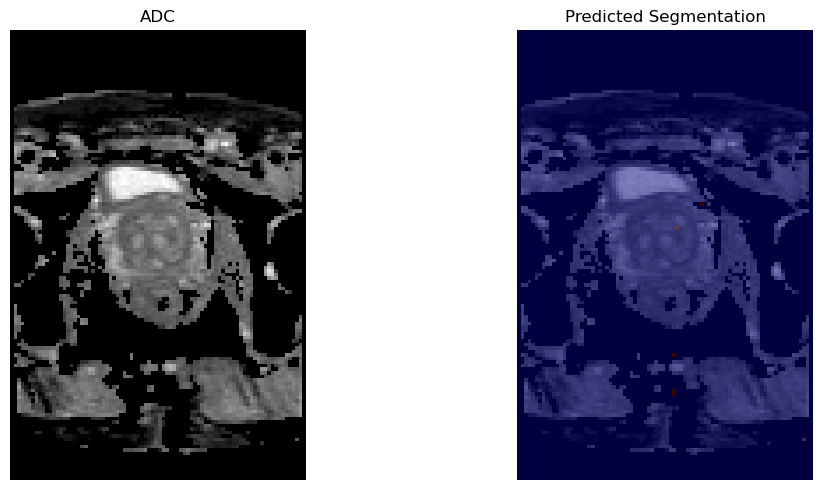

In [1]:
import torch
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord, Resize
from monai.networks.nets import BasicUNet

# ==== Load model ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicUNet(spatial_dims=3, in_channels=2, out_channels=2).to(device)
model.load_state_dict(torch.load("prostate_seg_model.pth", map_location=device))
model.eval()

# ==== Load patient ====
proxid = "ProstateX-0100"
adc_path = f"images/{proxid}_adc.nii.gz"
ktrans_path = f"images/{proxid}_ktrans.nii.gz"

# ==== Preprocessing ====
inference_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    ScaleIntensityd(keys="image"),
    ToTensord(keys="image")
])

sample = {"image": [adc_path, ktrans_path]}
sample = inference_transforms(sample)

input_tensor = sample["image"].unsqueeze(0).to(device)  # shape: [1, 2, D, H, W]

# ==== Predict ====
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()  # shape: [D, H, W]

# ==== Match ADC shape ====
adc_img = sitk.ReadImage(adc_path)
adc_np = sitk.GetArrayFromImage(adc_img)  # shape: [D, H, W]

# Resize prediction to match ADC shape (if needed)
if pred.shape != adc_np.shape:
    print(f"⚠️ Resizing prediction from {pred.shape} to match {adc_np.shape}")
    pred_itk = sitk.GetImageFromArray(pred.astype(np.uint8))
    pred_itk = sitk.Resample(pred_itk, adc_img, interpolator=sitk.sitkNearestNeighbor)
    pred = sitk.GetArrayFromImage(pred_itk)

# ==== Visualise a middle slice ====
slice_idx = adc_np.shape[0] // 2

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("ADC")
plt.imshow(adc_np[slice_idx], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation")
plt.imshow(adc_np[slice_idx], cmap="gray")
plt.imshow(pred[slice_idx], alpha=0.5, cmap="jet")
plt.axis("off")

plt.tight_layout()
plt.show()
